## Install Packages

In [1]:
!conda install -y -c conda-forge faiss-gpu
!apt-get -y update
!apt-get -y install libatlas-base-dev

done
Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with repodata from current_repodata.json, will retry with next repodata source.
WARNING conda.models.version:get_matcher(540): Using .* with relational operator is superfluous and deprecated and will be removed in a future version of conda. Your spec was 1.8.0.*, but conda is ignoring the .* and treating it as 1.8.0
WARNING conda.models.version:get_matcher(540): Using .* with relational operator is superfluous and deprecated and will be removed in a future version of conda. Your spec was 1.6.0.*, but conda is ignoring the .* and treating it as 1.6.0
done
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.10.3
  latest version: 25.7.0

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - faiss-gpu


The followin

## Load Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.random_projection import GaussianRandomProjection

from tqdm import tqdm

import faiss

In [3]:
df = pd.read_csv("../story_dataset.csv")
df

,prompt_id,prompt,story,hidden_state_file,len_generated_story,len_new_story
0,1,Once upon a time there was a dragon,Once upon a time there was a dragon named Blaz...,./hidden_states/prompt_1.npz,270,271
1,1,Once upon a time there was a dragon,Once upon a time there was a dragon named Spar...,./hidden_states/prompt_1.npz,349,350
2,1,Once upon a time there was a dragon,Once upon a time there was a dragon named Scor...,./hidden_states/prompt_1.npz,278,278
3,1,Once upon a time there was a dragon,Once upon a time there was a dragon. The drago...,./hidden_states/prompt_1.npz,117,118
4,1,Once upon a time there was a dragon,Once upon a time there was a dragon. The drago...,./hidden_states/prompt_1.npz,129,130
...,...,...,...,...,...,...
9995,10,Once upon a time there was a poor boy,Once upon a time there was a poor boy named Ti...,./hidden_states/prompt_10.npz,289,290
9996,10,Once upon a time there was a poor boy,Once upon a time there was a poor boy named Ti...,./hidden_states/prompt_10.npz,119,119
9997,10,Once upon a time there was a poor boy,Once upon a time there was a poor boy named Ti...,./hidden_states/prompt_10.npz,127,128
9998,10,Once upon a time there was a poor boy,Once upon a time there was a poor boy named Ti...,./hidden_states/prompt_10.npz,441,441


In [4]:
max_story_len = max(df["len_generated_story"])
max_story_len

522

In [5]:
hidden_states_by_layer = {}
NUM_PROMPTS = 10

for prompt_id in range(1, NUM_PROMPTS + 1):
    with np.load(f'../hidden_states/prompt_{prompt_id}.npz') as loaded_data:
        for i in tqdm(range(1000)):
            curr_hidden_states = loaded_data[f"arr_{i}"][0]
#             print(curr_hidden_states.shape)
            for layer in range(5, 6):
                padded_arr = np.zeros((max_story_len, 512))
                padded_arr_len = len(curr_hidden_states[layer][0])
                
                padded_arr[:padded_arr_len] = curr_hidden_states[layer][0]
                
                padded_arr = padded_arr.flatten().astype('float32') #FAISS expects data in type float32 instead of float64 - saves memory too!
#                 print(padded_arr.shape)
                
                if(f"layer_{layer}" in hidden_states_by_layer):
                    hidden_states_by_layer[f"layer_{layer}"].append(padded_arr)
                else:
                    hidden_states_by_layer[f"layer_{layer}"] = [padded_arr]

100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:39<00:00, 10.07it/s]


In [6]:
layer_hs_array = np.array(hidden_states_by_layer["layer_5"])
layer_hs_array.shape

(10000, 267264)

## Layer 5 Clustering

In [7]:
# Use original vectors for clustering - uncomment next line and comment out last two lines

# dim_reduced_vecs = layer_hs_array

random_projector = GaussianRandomProjection(random_state = 42)
dim_reduced_vecs = random_projector.fit_transform(layer_hs_array).astype('float32')

In [8]:
dim_reduced_vecs = np.array([v / np.linalg.norm(v) for v in dim_reduced_vecs])
dim_reduced_vecs.shape

(10000, 7894)

In [9]:
prompt_ids = df["prompt_id"]
prompt_ids = prompt_ids.to_numpy()
prompt_ids

array([ 1,  1,  1, ..., 10, 10, 10])

In [10]:
X_train = np.zeros((int(0.8 * dim_reduced_vecs.shape[0]), dim_reduced_vecs.shape[1]), dtype = np.float32)
y_train = np.zeros(int(0.8 * dim_reduced_vecs.shape[0]))

X_test = np.zeros((int(0.2 * dim_reduced_vecs.shape[0]), dim_reduced_vecs.shape[1]), dtype = np.float32)
y_test = np.zeros(int(0.2 * dim_reduced_vecs.shape[0]))

In [11]:
for i in range(10):
    X_train[i * 800 : (i + 1) * 800] = dim_reduced_vecs[i * 1000 : (i * 1000) + 800]
    y_train[i * 800 : (i + 1) * 800] = prompt_ids[i * 1000 : (i * 1000) + 800]
    
    X_test[i * 200 : (i + 1) * 200] = dim_reduced_vecs[(i * 1000) + 800 : (i + 1) * 1000]
    y_test[i * 200 : (i + 1) * 200] = prompt_ids[(i * 1000) + 800 : (i + 1) * 1000]

In [12]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(8000, 7894)
(8000,)
(2000, 7894)
(2000,)


Sampling a subset of 4000 / 8000 for training
Clustering 4000 points in 7894D to 5 clusters, redo 10 times, 20 iterations
  Preprocessing in 0.13 s
Outer iteration 0 / 10
  Iteration 19 (0.59 s, search 0.29 s): objective=2161.97 imbalance=1.079 nsplit=0       
Objective improved: keep new clusters
Outer iteration 1 / 10
  Iteration 19 (1.19 s, search 0.58 s): objective=2164.32 imbalance=1.243 nsplit=0       
Objective improved: keep new clusters
Outer iteration 2 / 10
  Iteration 19 (1.78 s, search 0.87 s): objective=2161.28 imbalance=1.098 nsplit=0       
Outer iteration 3 / 10
  Iteration 19 (2.37 s, search 1.15 s): objective=2164.49 imbalance=1.137 nsplit=0       
Objective improved: keep new clusters
Outer iteration 4 / 10
  Iteration 19 (2.96 s, search 1.44 s): objective=2156.74 imbalance=1.497 nsplit=0       
Outer iteration 5 / 10
  Iteration 19 (3.56 s, search 1.73 s): objective=2161.9 imbalance=1.244 nsplit=0        
Outer iteration 6 / 10
  Iteration 19 (4.14 s, search 2.02 s

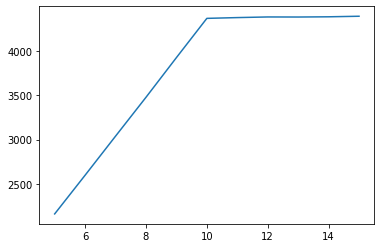

In [13]:
# Elbow Plot
niter = 20
verbose = True
dim = X_train.shape[1]

k_vals = [k for k in range(5, 16)]
wccs = []
for k in k_vals:
    kmeans = faiss.Kmeans(dim, k, niter = niter, verbose = verbose, gpu = True, nredo = 10, spherical = True, max_points_per_centroid = 800)
    kmeans.train(X_train)
    wccs.append(kmeans.obj[-1])

plt.plot(k_vals, wccs)

In [14]:
# K-means Clustering

# ncentroids = NUM_PROMPTS
ncentroids = 10 # Elbow point - based on objective (sum of cosine similarities)
niter = 20
verbose = True
dim = X_train.shape[1]
kmeans = faiss.Kmeans(dim, ncentroids, niter = niter, verbose = verbose, gpu = True, nredo = 10, spherical = True, max_points_per_centroid = 800)
kmeans.train(X_train)


Clustering 8000 points in 7894D to 10 clusters, redo 10 times, 20 iterations
  Preprocessing in 0.05 s
Outer iteration 0 / 10
  Iteration 19 (1.18 s, search 0.59 s): objective=4331.51 imbalance=1.778 nsplit=0       
Objective improved: keep new clusters
Outer iteration 1 / 10
  Iteration 19 (2.36 s, search 1.18 s): objective=4352.69 imbalance=1.382 nsplit=0       
Objective improved: keep new clusters
Outer iteration 2 / 10
  Iteration 19 (3.54 s, search 1.77 s): objective=4341.32 imbalance=1.693 nsplit=0       
Outer iteration 3 / 10
  Iteration 19 (4.72 s, search 2.37 s): objective=4363.91 imbalance=1.384 nsplit=0       
Objective improved: keep new clusters
Outer iteration 4 / 10
  Iteration 19 (5.90 s, search 2.96 s): objective=4344.54 imbalance=2.205 nsplit=0       
Outer iteration 5 / 10
  Iteration 19 (7.07 s, search 3.55 s): objective=4318.18 imbalance=2.759 nsplit=0       
Outer iteration 6 / 10
  Iteration 19 (8.25 s, search 4.14 s): objective=4353.35 imbalance=1.369 nsplit=

4363.9072265625

In [15]:
kmeans.centroids #cluster centers

array([[ 5.28457249e-03, -1.66210625e-02,  8.61355476e-03, ...,
        -1.19138807e-02,  9.01207794e-03, -2.53765575e-05],
       [ 4.91311494e-03, -1.44728003e-02,  5.07042790e-03, ...,
        -7.66809797e-03,  5.20783523e-03,  4.72052628e-03],
       [ 9.81505215e-03, -1.33448625e-02,  8.22615344e-03, ...,
        -7.97653571e-03,  6.80622086e-03,  2.90112221e-03],
       ...,
       [ 9.01926961e-03, -1.87593512e-02,  8.92810430e-03, ...,
        -9.80232004e-03,  7.35407090e-03,  2.72854650e-03],
       [ 7.40805315e-03, -1.61627289e-02,  1.11839408e-02, ...,
        -6.31066738e-03,  6.19272981e-03,  7.97134545e-03],
       [ 7.00061861e-03, -1.29045658e-02,  1.79426149e-02, ...,
        -3.50890099e-03,  1.43031795e-02,  1.18114601e-03]], dtype=float32)

In [16]:
for centroid in kmeans.centroids:
    print(np.linalg.norm(centroid))

1.0
1.0
1.0
1.0000004
0.99999994
1.0
1.0000001
0.9999999
1.0000002
1.0


In [17]:
kmeans.obj #inertia at each iteration

array([2946.70532227, 4172.65673828, 4254.46337891, 4303.70117188,
       4323.00537109, 4325.73779297, 4327.05517578, 4328.08300781,
       4328.7109375 , 4329.32568359, 4329.95703125, 4330.47705078,
       4330.74072266, 4330.90039062, 4331.05175781, 4331.22851562,
       4331.36035156, 4331.45556641, 4331.49023438, 4331.51171875,
       2925.00073242, 4201.77490234, 4274.32470703, 4315.74560547,
       4336.83544922, 4347.34570312, 4351.00927734, 4351.75097656,
       4352.04589844, 4352.23242188, 4352.34570312, 4352.4140625 ,
       4352.45800781, 4352.49560547, 4352.55615234, 4352.59033203,
       4352.62109375, 4352.64355469, 4352.67285156, 4352.69433594,
       2834.69458008, 4190.49609375, 4275.55224609, 4312.96435547,
       4323.96826172, 4329.57714844, 4333.10693359, 4336.36083984,
       4338.71044922, 4339.84863281, 4340.87207031, 4341.13427734,
       4341.18359375, 4341.21386719, 4341.23925781, 4341.26074219,
       4341.27148438, 4341.2890625 , 4341.30566406, 4341.32324

In [18]:
cos_similarities = X_train @ kmeans.centroids.T
classifications_train = np.argmax(cos_similarities, axis=1)

In [19]:
pd.Series(classifications_train).value_counts()

6    2078
7    1251
5     842
2     808
0     679
1     590
4     576
9     444
3     396
8     336
dtype: int64

In [20]:
# Get most common label for each point classified to a centroid (same centroid)
centroid_labels = [np.where(classifications_train == i)[0] for i in range(ncentroids)]
max_label_per_centroid = [int(pd.Series(y_train[centroid_labels[i]]).value_counts().idxmax()) for i in range(ncentroids)]
max_label_per_centroid

[5, 1, 2, 10, 9, 5, 6, 6, 10, 3]

In [21]:
centroid_to_label = {idx : max_label_per_centroid[idx] for idx in range(len(max_label_per_centroid))}

In [22]:
centroid_to_label

{0: 5, 1: 1, 2: 2, 3: 10, 4: 9, 5: 5, 6: 6, 7: 6, 8: 10, 9: 3}

In [23]:
vectorized_map = np.vectorize(centroid_to_label.get)
classifications_to_label = vectorized_map(classifications_train)

classifications_to_label

array([ 6,  6,  6, ..., 10, 10, 10])

In [24]:
for i in range(10):
    print(f"Prompt {i + 1} Accuracy: ", np.mean(classifications_to_label[i * 800:(i + 1) * 800] == (i + 1)))

Prompt 1 Accuracy:  0.15
Prompt 2 Accuracy:  0.205
Prompt 3 Accuracy:  0.555
Prompt 4 Accuracy:  0.0
Prompt 5 Accuracy:  0.78
Prompt 6 Accuracy:  0.68625
Prompt 7 Accuracy:  0.0
Prompt 8 Accuracy:  0.0
Prompt 9 Accuracy:  0.12875
Prompt 10 Accuracy:  0.91


In [25]:
print(f"Overall Accuracy: ", np.mean(classifications_to_label == y_train))

Overall Accuracy:  0.3415


## Perform Inference on Test Set & Collect Test Accuracy

In [26]:
cos_similarities = X_test @ kmeans.centroids.T
classifications_test = np.argmax(cos_similarities, axis=1)

In [27]:
pd.Series(classifications_test).value_counts()

6    527
7    320
5    211
2    181
1    172
0    148
4    144
3    113
9    105
8     79
dtype: int64

In [28]:
classifications_to_label_test = vectorized_map(classifications_test)

classifications_to_label_test

array([ 6,  1,  5, ..., 10, 10, 10])

In [29]:
for i in range(10):
    print(f"Prompt {i + 1} Accuracy: ", np.mean(classifications_to_label_test[i * 200:(i + 1) * 200] == (i + 1)))

Prompt 1 Accuracy:  0.14
Prompt 2 Accuracy:  0.16
Prompt 3 Accuracy:  0.525
Prompt 4 Accuracy:  0.0
Prompt 5 Accuracy:  0.785
Prompt 6 Accuracy:  0.66
Prompt 7 Accuracy:  0.0
Prompt 8 Accuracy:  0.0
Prompt 9 Accuracy:  0.145
Prompt 10 Accuracy:  0.95


In [30]:
print(f"Overall Accuracy: ", np.mean(classifications_to_label_test == y_test))

Overall Accuracy:  0.3365


## Confusion Matrix of Results

In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

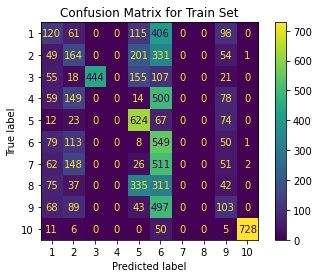

In [32]:
cm = confusion_matrix(y_train, classifications_to_label)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f"{i}" for i in range(1, 11)])

disp.plot()
plt.title('Confusion Matrix for Train Set')
plt.show()

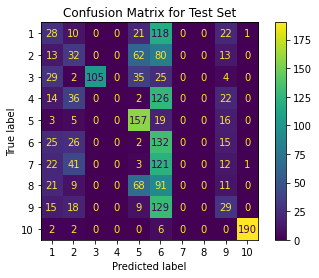

In [33]:
cm = confusion_matrix(y_test, classifications_to_label_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f"{i}" for i in range(1, 11)])

disp.plot()
plt.title('Confusion Matrix for Test Set')
plt.show()